In [1]:
import uproot
import pandas as pd
#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def root_to_df(path,input_filename,features,treeName,n_events):
    ufile = uproot.open(path+input_filename)
    tree = ufile[treeName]
    df = tree.arrays(features, library="pd",entry_stop=n_events)
    return df



In [3]:
path = "/home/sabaterj/code/faser/photon-reco-py/scripts/discriminating_variables/output/"
file_genie_numu = "genie_numu.root"
file_genie_anumu = "genie_anumu.root"
file_genie_nue = "genie_nue.root"
treeName = "myTree"
n_events = -1
#features = ["n_hits","qdmax","n_layers"]
features = ["tower_q_max","n_hits_5","q_max","q_2nd_max","q_frac_layer1_tot","n_hits_4","qmax_qtot"]
'''
features = ["n_layers","q_max","q_2nd_max","q_frac_1","q_frac_3","q_frac_10","q_frac_100","qmin_valley","qdmax","q_frac_layer1_tot","q_frac_layer2_tot","q_frac_layer3_tot","q_frac_layer4_tot","q_frac_layer5_tot","q_frac_layer6_tot", "q_frac_layer1_layer6","q_frac_layer2_layer6","q_frac_layer3_layer6","q_frac_layer4_layer6","q_frac_layer5_layer6","q_frac_layer6_layer6",
"w10st_6","w30st_6","w100st_6","w10st_5","w30st_5","w100st_5","w10st_4","w30st_4","w100st_4","w500st_5",
"tower_q_max","tower_q_2nd_max","tower_qdmax","tower_q_frac_1","tower_q_frac_3","tower_q_frac_10","tower_q_frac_100","tower_w10st","tower_w30st","tower_w100st","theta_1st_last","qmax_qtot","qmax2ndmax_qtot", "kappa_10mm", "asym_10mm", "r2_10mm", "eigen_ratio_10mm", "eccentricity_10mm","rot_angle_10mm", "kappa_15mm", "asym_15mm", "r2_15mm", "eigen_ratio_15mm", "eccentricity_15mm","rot_angle_15mm","kappa_20mm", "asym_20mm", "r2_20mm", "eigen_ratio_20mm", "eccentricity_20mm","rot_angle_20mm", "eigen_ratio_25mm", "eccentricity_25mm","rot_angle_25mm",
"n_hits","n_hits_1","n_hits_2","n_hits_3","n_hits_4","n_hits_5","n_hits_6","q_tot","q_tot_1","q_tot_2","q_tot_3","q_tot_4","q_tot_5","q_tot_6","d_barycenter_qmax","d_barycenter_q2ndmax","d_1st_2nd_max","track_angle"]
'''
numu_df = root_to_df(path=path,input_filename=file_genie_numu,features=features,treeName=treeName,n_events=n_events)
anumu_df = root_to_df(path=path,input_filename=file_genie_anumu,features=features,treeName=treeName,n_events=n_events)
nue_df = root_to_df(path=path,input_filename=file_genie_nue,features=features,treeName=treeName,n_events=n_events)
file_signal = "signal/signal.root"
sig_df = root_to_df(path=path,input_filename=file_signal,features=features,treeName=treeName,n_events=n_events)
# add a label to distinguish signal from background
numu_df['is_signal'] = 0
anumu_df['is_signal'] = 0
nue_df['is_signal'] = 0
sig_df['is_signal'] = 1


In [4]:
sig_df.head()

,tower_q_max,n_hits_5,q_max,q_2nd_max,q_frac_layer1_tot,n_hits_4,qmax_qtot,is_signal
0,8.309048,71,8.309048,6.443474,0.000000,75,0.020803,1
1,53.876233,125,19.214424,17.322093,0.005518,83,0.023745,1
2,4.754299,44,4.754299,4.680439,0.000000,16,0.032834,1
3,181.391387,367,56.026034,56.026034,0.001795,204,0.021970,1
4,7.952564,154,7.952564,7.057428,0.004763,51,0.011831,1


In [5]:
# merge the signal and bkg dataframe
df = pd.concat([sig_df, numu_df, nue_df, anumu_df], axis=0)
df.head()

,tower_q_max,n_hits_5,q_max,q_2nd_max,q_frac_layer1_tot,n_hits_4,qmax_qtot,is_signal
0,8.309048,71,8.309048,6.443474,0.000000,75,0.020803,1
1,53.876233,125,19.214424,17.322093,0.005518,83,0.023745,1
2,4.754299,44,4.754299,4.680439,0.000000,16,0.032834,1
3,181.391387,367,56.026034,56.026034,0.001795,204,0.021970,1
4,7.952564,154,7.952564,7.057428,0.004763,51,0.011831,1


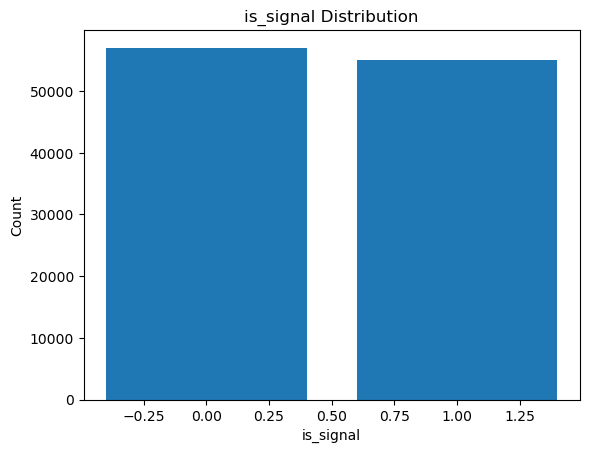

In [6]:
# Check how many events we have in each class
class_counts = df['is_signal'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('is_signal')
plt.ylabel('Count')
plt.title('is_signal Distribution')
plt.show()

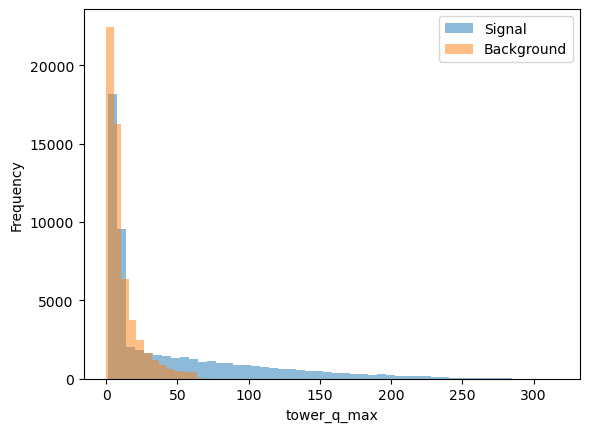

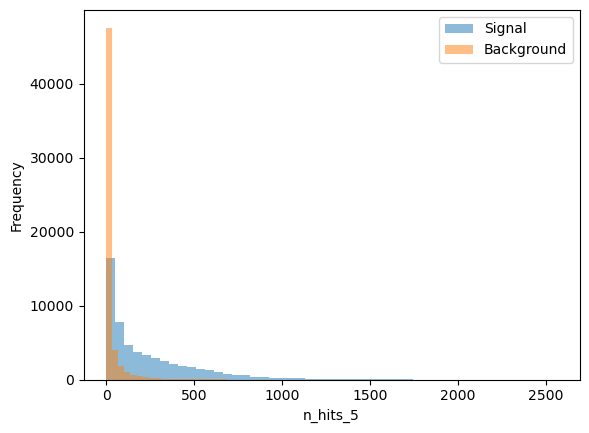

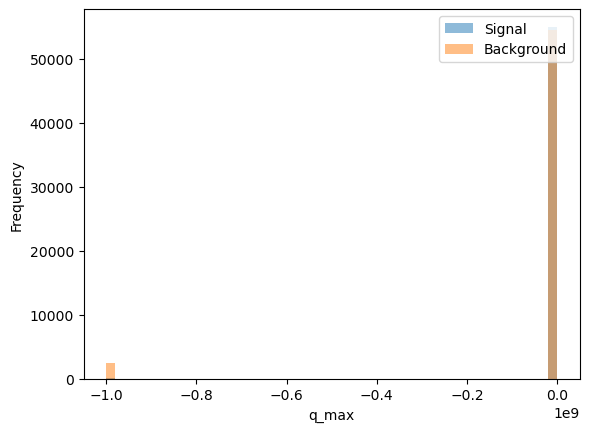

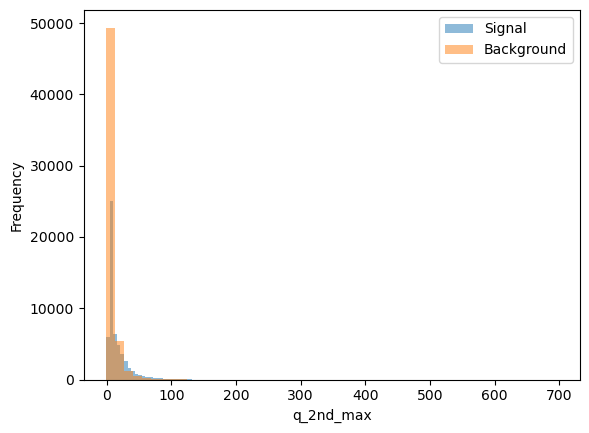

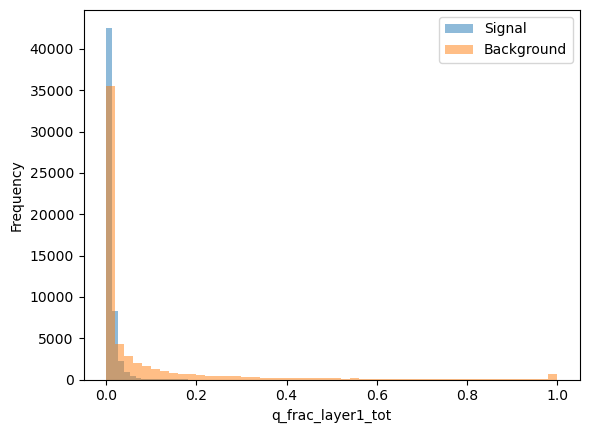

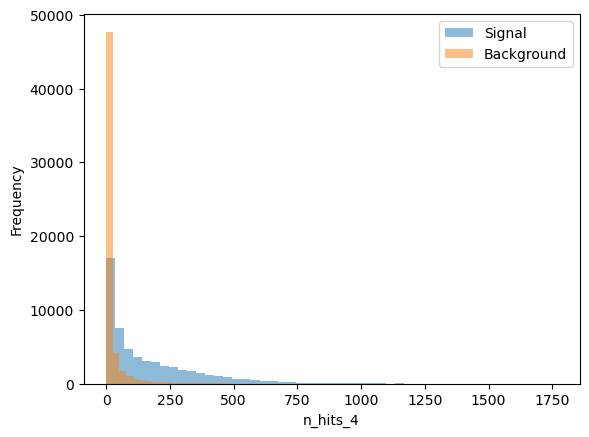

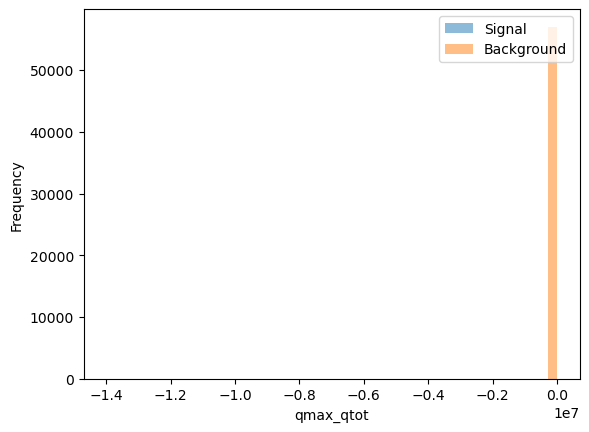

In [7]:
for ifeature in features:
    # Separate data based on 'is_signal'
    signal_data = df[df['is_signal'] == 1][ifeature]
    background_data = df[df['is_signal'] == 0][ifeature]

    # Plot histograms
    plt.hist(signal_data, bins=50, alpha=0.5, label='Signal')
    plt.hist(background_data, bins=50, alpha=0.5, label='Background')

    # Add labels and legend
    plt.xlabel(ifeature)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    # Show plot
    plt.show()

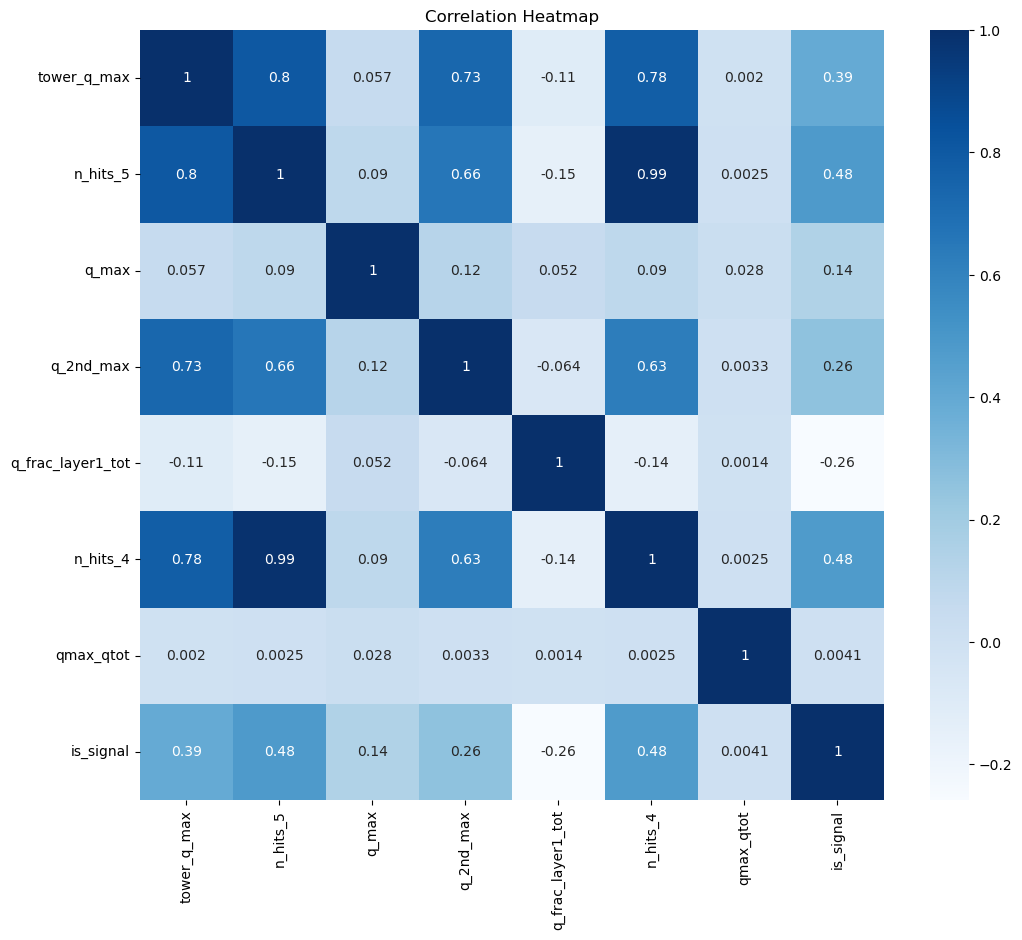

In [8]:
# Calculate the correlation matrix
corr_matrix = df.corr()
# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# definy my x and y dropping the is_signal column
x = df.drop('is_signal', axis=1)
y = df['is_signal']
x.head()

,tower_q_max,n_hits_5,q_max,q_2nd_max,q_frac_layer1_tot,n_hits_4,qmax_qtot
0,8.309048,71,8.309048,6.443474,0.000000,75,0.020803
1,53.876233,125,19.214424,17.322093,0.005518,83,0.023745
2,4.754299,44,4.754299,4.680439,0.000000,16,0.032834
3,181.391387,367,56.026034,56.026034,0.001795,204,0.021970
4,7.952564,154,7.952564,7.057428,0.004763,51,0.011831


In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

[0]	validation_0-logloss:0.35364	validation_1-logloss:0.35564
[1]	validation_0-logloss:0.30033	validation_1-logloss:0.30190
[2]	validation_0-logloss:0.27732	validation_1-logloss:0.27798
[3]	validation_0-logloss:0.25783	validation_1-logloss:0.25734
[4]	validation_0-logloss:0.25306	validation_1-logloss:0.25267
[5]	validation_0-logloss:0.24337	validation_1-logloss:0.24499
[6]	validation_0-logloss:0.23952	validation_1-logloss:0.24289
[7]	validation_0-logloss:0.23546	validation_1-logloss:0.23931
[8]	validation_0-logloss:0.23279	validation_1-logloss:0.23647
[9]	validation_0-logloss:0.23138	validation_1-logloss:0.23511
[10]	validation_0-logloss:0.22907	validation_1-logloss:0.23273
[11]	validation_0-logloss:0.22713	validation_1-logloss:0.23130
[12]	validation_0-logloss:0.22551	validation_1-logloss:0.23094
[13]	validation_0-logloss:0.22466	validation_1-logloss:0.23053
[14]	validation_0-logloss:0.22382	validation_1-logloss:0.23019
[15]	validation_0-logloss:0.22291	validation_1-logloss:0.22936
[1

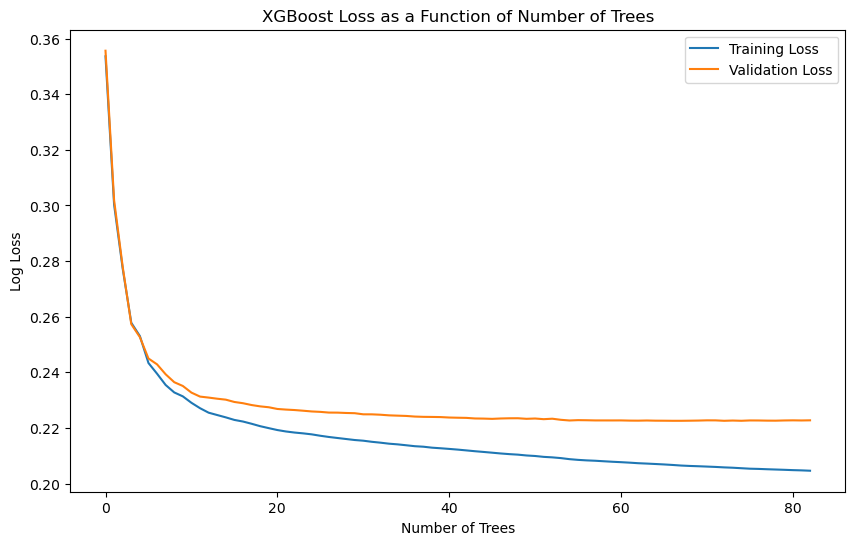

In [24]:
# Declare parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,  # maximum depth per tree
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100,  # number of trees
    'early_stopping_rounds': 10,
}

# Define your XGBoost classifier with parameters
xgboost = xgb.XGBClassifier(**params, random_state=42)

# Train the model and specify evaluation data
evals_result = {}  # Dictionary to store evaluation results
xgboost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
#xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
# retrieve performance metrics
evals_result = xgboost.evals_result()

# Extract the training and validation loss from the evaluation results
train_loss = evals_result['validation_0']['logloss']
val_loss = evals_result['validation_1']['logloss']

# Plot the training and validation loss as a function of the number of trees
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Loss as a Function of Number of Trees')
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

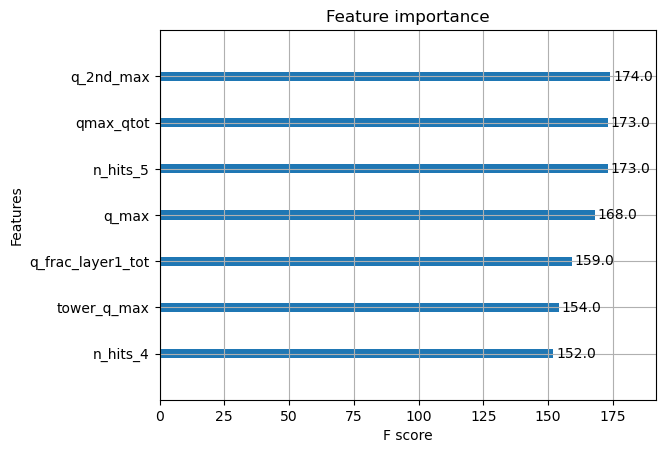

In [12]:
xgb.plot_importance(xgboost)

In [13]:
# load JS visualization code to notebook
shap.initjs()

In [14]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_train)

[14:31:06] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [15]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


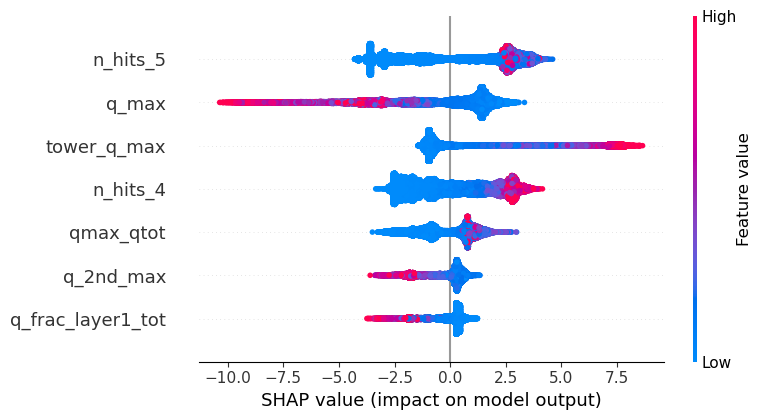

In [16]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

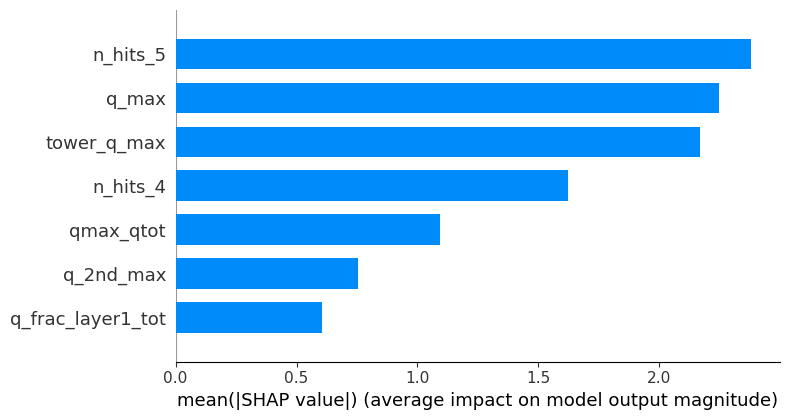

In [17]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [18]:
xgboost.save_model('model.json')

In [19]:
retrain_MVA = False
param_grid = [
    {'subsample': [0.5], 'n_estimators': range(60, 220, 40), 
     'max_depth': range (2, 10, 1), 'learning_rate': [0.02],
     'colsample_bytree': [0.4], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2],
     'learning_rate': [0.1, 0.01, 0.05]}
]
param_grid = [
    {#'subsample': [0.5], 
     'n_estimators': range(60, 220, 40), 
     'max_depth': range (2, 10, 1), 
     #'colsample_bytree': [0.4], 
     #'colsample_bylevel': [0.5],
     #'reg_alpha':[1], 'reg_lambda': [1], 
     'min_child_weight':[2],
     'learning_rate': [0.1, 0.01, 0.05]}
]
grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=param_grid,
    scoring = 'neg_log_loss',
    n_jobs = 10,
    cv = 10,
    verbose=True
)


In [20]:
if retrain_MVA:
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    print(grid_search.best_score_)